# **Introduction:**

This file serves to host an artificial neural network (ANN) implementation for use in multi-robot task allocation through regression on FIS-generated data. The goal for designing this FIS is to compare its performance against an ANFIS to determine which is better at approximating the FIS, which will be achieved through using the coefficient of determination ($R^{2}$), root mean squared error (RMSE), and mean absolute error (MAE).

**Date Created:** 12/12/2024

**Date Modified:** 12/12/2024


# **Import Packages:**

This section imports all necessary packages for the ANN implementation.



In [85]:
# import packages:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import time
import json

# **Data Loading & Discovery:**

This section loads the data that was generated from the FIS. 

In [86]:
# get the path to the data CSV
files_in_dir = os.listdir(os.getcwd())
data_path = os.path.join(os.getcwd(), files_in_dir[files_in_dir.index('V3_Data.csv')])
print(f"data path is: {data_path}")

# load the CSV as a pandas dataframe:
df = pd.read_csv(data_path)
print(f"data successfully loaded")

# inspect some members of the dataframe:
print(f"dataframe shape is: {df.shape}")
print(f"columns are: {list(df.columns)}\n")
df.head()

data path is: c:\Users\mtidd2\Desktop\Research\fis_design\Python_Design\ANN_Design\V3_Data.csv
data successfully loaded
dataframe shape is: (15000, 4)
columns are: ['Load History', 'Distance to Task', 'Total Distance Travelled', 'Suitability']



,Load History,Distance to Task,Total Distance Travelled,Suitability
0,4.0,13.0,42.0,3.312951
1,0.0,12.0,15.0,6.003929
2,9.0,11.0,9.0,4.140384
3,0.0,20.0,7.0,4.521692
4,1.0,2.0,44.0,5.133376


Going to check the distribution of each input variable, as well as the suitability:

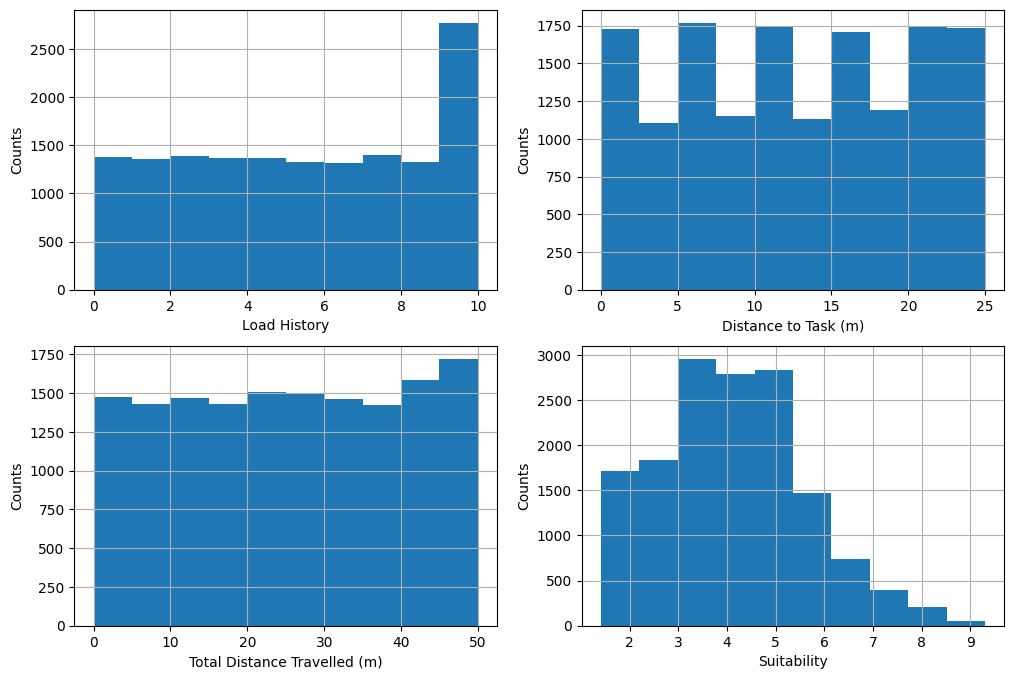

In [87]:
# get histogram of each column:

fig = plt.figure(figsize = (12,8))
plt.subplot(2,2,1)
df['Load History'].hist()
plt.xlabel('Load History')
plt.ylabel('Counts')
plt.subplot(2,2,2)
df['Distance to Task'].hist()
plt.xlabel('Distance to Task (m)')
plt.ylabel('Counts')
plt.subplot(2,2,3)
df['Total Distance Travelled'].hist()
plt.xlabel('Total Distance Travelled (m)')
plt.ylabel('Counts')
plt.subplot(2,2,4)
df['Suitability'].hist()
plt.xlabel('Suitability')
plt.ylabel('Counts')
plt.show()

# **Pre-process Data:**

This section will split the data into training, validation, and testing, alongside performing some pre-processing.

In [88]:
# get feature and label dataframes:
x_data = df.drop(['Suitability'], axis = 1)
y_data = df['Suitability']

Need to first standardize the values:

In [89]:
# define scaler:
scaler = StandardScaler()
x_data_scaled = scaler.fit_transform(x_data)

Split data into training, validation, and testing:

In [90]:
# split dataset:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5)

# get split results:
print(f"there are {x_train.shape[0]} training examples")
print(f"there are {x_val.shape[0]} validation examples")
print(f"there are {x_test.shape[0]} testing examples")

# get input shape:
INPUT_SHAPE = x_data.shape[1]

there are 12000 training examples
there are 1500 validation examples
there are 1500 testing examples


# **Model Exploration:**

Within this section, a function is defined for instantiating models using the Keras API, for use in performing a hyperparameter search to determine the best combination of hyperparameters. The hyperparameters that are being considered are:

* number of hidden layers
* number of hidden neurons
* number of epochs
* learning rate
* using batch normalization vs. not using batch normalization
* using dropout vs. not using dropout
* activation function
* batch size

In [91]:
# define parameter values to be explored:
# num_hidden_layers = [1, 2, 3]
# num_hidden_neurons = [16, 32, 64]
# num_epochs = [50, 150, 250]
# learning_rates = [0.001, 0.0005, 0.0001]
# activation_functions = ['relu', 'sigmoid']
# batch_sizes = [32, 64, 128, 256]
num_hidden_layers = [1]
num_hidden_neurons = [16]
num_epochs = [50]
learning_rates = [0.0001]
activation_functions = ['relu']
batch_sizes = [64]

LOSS_FUNCTION = 'mse'
METRICS = ['mae', keras.metrics.RootMeanSquaredError()]

Define a model generation function:

In [92]:
# define function:

def make_model(layers, neurons, rate, norm, drop, activation):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Dense(neurons, activation = activation, input_shape = (INPUT_SHAPE, ), name = f'hidden_layer_{i+1}'))
        else:
            model.add(Dense(neurons, activation = activation, name = f'hidden_layer_{i+1}'))
        
        if norm == True:
            model.add(BatchNormalization(name = f'batch_norm_layer_{i+1}'))
        
        if drop == True:
            model.add(Dropout(0.2, name = f'dropout_layer_{i+1}'))
        
    # add output layer:
    model.add(Dense(1, activation = 'linear', name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = LOSS_FUNCTION,
                  metrics = METRICS)
    
    return model

Now we must perform the grid search. This process entails:

* Creating a model using the aforementioned "make_model()" function
* Save the parameters used in the creation of the model within dictionary called "model_params"
* Train the model, saving results into a dictionary called "training results"

While iterating through each combination of parameters.

In [93]:
# set up grid search:
for layer in num_hidden_layers:
    for neurons in num_hidden_neurons:
        for epochs in num_epochs:
            for rate in learning_rates:
                for function in activation_functions:
                    for batch in batch_sizes:

                        # make directory to save into:
                        output_dir = os.path.join(os.getcwd(), f"ann_search_results/{str(layer)}_{str(neurons)}_{str(epochs)}_{str(rate)}_{str(function)}_{str(batch)}")
                        os.makedirs(output_dir, exist_ok = True)

                        # build a model:
                        tf.keras.backend.clear_session()
                        model = make_model(layer, neurons, rate, True, True, function)

                        # save training parameters into a dictionary:
                        training_params = {
                            'num_layers' : layer,
                            'num_neurons' : neurons,
                            'num_epochs' : epochs,
                            'learning_rate' : rate,
                            'activation_function' : function,
                            'use_batch_norm' : True,
                            'use_dropout' : True,
                            'batch_size' :  batch
                        }

                        # train model:
                        train_start = time.time()
                        history = model.fit(x_train, y_train, 
                                            epochs = epochs,
                                            batch_size = batch,
                                            validation_data = [x_val, y_val]
                                            )
                        train_time = time.time() - train_start

                        # store training results:
                        training_results = {}
                        for i in history.history.keys():
                            training_results[i] = history.history[i][-1]
                        training_results['train_time'] = train_time

                        # save both results to a directory:
                        params_path = os.path.join(output_dir, "params_results.json")
                        with open(params_path, "w") as f:
                            json.dump({'parameters': training_params, 'results': training_results}, f, indent = 4)


Epoch 1/50


c:\Users\mtidd2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 20.8103 - mae: 4.1019 - root_mean_squared_error: 4.5617 - val_loss: 20.1738 - val_mae: 4.1499 - val_root_mean_squared_error: 4.4915
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 18.6645 - mae: 3.9400 - root_mean_squared_error: 4.3202 - val_loss: 19.1526 - val_mae: 4.1137 - val_root_mean_squared_error: 4.3764
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 17.2981 - mae: 3.8297 - root_mean_squared_error: 4.1589 - val_loss: 17.4579 - val_mae: 3.9753 - val_root_mean_squared_error: 4.1783
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 15.8256 - mae: 3.7076 - root_mean_squared_error: 3.9778 - val_loss: 15.8096 - val_mae: 3.8241 - val_root_mean_squared_error: 3.9761
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 14.5025 - mae: 3.5924 - root_mean_squared_error: 3.8078 - val_loss: 14.0923 - val_mae: 3.6340 - val_root_mean_squared_error: 3.7540
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 